In [24]:
import warnings
warnings.filterwarnings("ignore")

from astropy.io import fits
from astropy.wcs import WCS
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sedcreator import SedFluxer, SedFitter
from astropy.visualization import simple_norm
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5
# from astroquery.vizier import Vizier;Vizier.ROW_LIMIT=-1
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
# from photutils.aperture import EllipticalAperture
# from photutils.aperture import RectangularAperture, ApertureStats, CircularAperture
from astropy.nddata import CCDData
# from ccdproc import ImageFileCollection
from astropy.stats import mad_std
# import ccdproc as ccdp
from pathlib import Path
import os
# from ccdproc import wcs_project
# import astroalign as aa
# from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
# from photutils.datasets import load_star_image
from astropy.modeling import models, fitting
# from astroquery.gaia import Gaia
from scipy.integrate import quad
import numpy as np
from scipy import optimize as opt
import copy
from scipy.spatial import distance
import skimage.io
# from microfilm.microplot import microshow
# from microfilm.microplot import Micropanel
# from microfilm import colorify
# from astropy.coordinates import Angle
# from photutils.aperture import aperture_photometry
# from astropy.visualization.wcsaxes import add_beam, add_scalebar
import math
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib.patches import Rectangle, Circle
from scipy import ndimage
# from astroquery.esasky import ESASky
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import make_lupton_rgb
%matplotlib notebook
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [30]:
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# Define the range and increment for age array
start = 1e6  # 1 million
end = 20e6   # 20 million
increment = 2e6  # 500,000
# Create log age array
age_arr = np.arange(start, end + increment, increment)
print(age_arr)
age_arr = np.log10(age_arr)

# define other isochrone parameters
AKs = 3
dist = 8000
evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
# filt_list = ['jwst,F162M', 'jwst,F200W']
# filt_list = ['jwst,F162M', 'jwst,F182M', 'jwst,F200W', 'jwst,F212N']
filt_list = ['jwst,F182M', 'jwst,F212N']
iso_dir = 'isochrones/'

instances = np.empty(len(age_arr), dtype=object)

for i in range(len(age_arr)):
    print("create isochrone with age " + str(i + 1) + " of " + str(len(age_arr)))
    my_iso = synthetic.IsochronePhot(age_arr[i], AKs, dist, metallicity=0,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso

[ 1000000.  3000000.  5000000.  7000000.  9000000. 11000000. 13000000.
 15000000. 17000000. 19000000. 21000000.]
create isochrone with age 1 of 11
create isochrone with age 2 of 11
create isochrone with age 3 of 11
create isochrone with age 4 of 11
create isochrone with age 5 of 11
create isochrone with age 6 of 11
create isochrone with age 7 of 11
create isochrone with age 8 of 11
create isochrone with age 9 of 11
create isochrone with age 10 of 11
create isochrone with age 11 of 11


In [33]:
iX = 500

F182M = pd.read_csv('jwst-data/jw04147-o012_t001_nircam_clear-f182m_cat.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'])
F182M = F182M[263:]
F182M.reset_index(inplace=True)
print("f182m read")

F182Mi10 = F182M[:iX]

for x in range(iX):
    F182Mi10['aper_total_vegamag'][x] = float(F182M['aper_total_vegamag'][x])
    F182Mi10['sky_centroid.dec'][x] = float(F182M['sky_centroid.dec'][x])
    F182Mi10['sky_centroid.ra'][x] = float(F182M['sky_centroid.ra'][x])
print("f182m floated")

F212N = pd.read_csv('jwst-data/jw04147-o012_t001_nircam_clear-f212n_cat.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'])
F212N = F212N[263:]
F212N.reset_index(inplace=True)
print("f212n read")

F212Ni10 = F212N[:iX]

for x in range(iX):
    F212Ni10['aper_total_vegamag'][x] = float(F212N['aper_total_vegamag'][x])
    F212Ni10['sky_centroid.dec'][x] = float(F212N['sky_centroid.dec'][x])
    F212Ni10['sky_centroid.ra'][x] = float(F212N['sky_centroid.ra'][x])
print("f212n floated")

F182M_coords = SkyCoord(ra=F182Mi10['sky_centroid.ra'],dec=F182Mi10['sky_centroid.dec'],unit=u.deg,frame='fk5')
F212N_coords = SkyCoord(ra=F212Ni10['sky_centroid.ra'],dec=F212Ni10['sky_centroid.dec'],unit=u.deg,frame='fk5')
print("coords matched")

f182m read
f182m floated
f212n read
f212n floated
coords matched


In [27]:
'''converters = {
        'aper_total_vegamag': float,
        'sky_centroid.dec': float,
        'sky_centroid.ra': float
    }

F182M = pd.read_csv('jwst-data/jw04147-o012_t001_nircam_clear-f182m_cat.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'],
                       converters=converters)
F182M = F182M[263:]
F182M.reset_index(inplace=True)
print("f182m read")

F212N = pd.read_csv('jwst-data/jw04147-o012_t001_nircam_clear-f212n_cat.ecsv', sep=" ", skiprows=1, names = ['el','xcentroid','ycentroid','sky_centroid.ra','sky_centroid.dec','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_50_30','CI_70_50','CI_70_30','is_extended','sharpness','roundness','nn_label','nn_dist','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll.ra','sky_bbox_ll.dec','sky_bbox_ul.ra','sky_bbox_ul.dec','sky_bbox_lr.ra','sky_bbox_lr.dec','sky_bbox_ur.ra','sky_bbox_ur.dec'],
                       converters=converters)
F212N = F212N[263:]
F212N.reset_index(inplace=True)
print("f212n read")


F182M_coords = SkyCoord(ra=F182M['sky_centroid.ra'],dec=F182M['sky_centroid.dec'],unit=u.deg,frame='fk5')
F212N_coords = SkyCoord(ra=F212N['sky_centroid.ra'],dec=F212N['sky_centroid.dec'],unit=u.deg,frame='fk5')
print("coords matched")
'''

'converters = {\n        \'aper_total_vegamag\': float,\n        \'sky_centroid.dec\': float,\n        \'sky_centroid.ra\': float\n    }\n\nF182M = pd.read_csv(\'jwst-data/jw04147-o012_t001_nircam_clear-f182m_cat.ecsv\', sep=" ", skiprows=1, names = [\'el\',\'xcentroid\',\'ycentroid\',\'sky_centroid.ra\',\'sky_centroid.dec\',\'aper_bkg_flux\',\'aper_bkg_flux_err\',\'aper30_flux\',\'aper30_flux_err\',\'aper50_flux\',\'aper50_flux_err\',\'aper70_flux\',\'aper70_flux_err\',\'aper_total_flux\',\'aper_total_flux_err\',\'aper30_abmag\',\'aper30_abmag_err\',\'aper50_abmag\',\'aper50_abmag_err\',\'aper70_abmag\',\'aper70_abmag_err\',\'aper_total_abmag\',\'aper_total_abmag_err\',\'aper30_vegamag\',\'aper30_vegamag_err\',\'aper50_vegamag\',\'aper50_vegamag_err\',\'aper70_vegamag\',\'aper70_vegamag_err\',\'aper_total_vegamag\',\'aper_total_vegamag_err\',\'CI_50_30\',\'CI_70_50\',\'CI_70_30\',\'is_extended\',\'sharpness\',\'roundness\',\'nn_label\',\'nn_dist\',\'isophotal_flux\',\'isophotal_flux_e

<IPython.core.display.Javascript object>


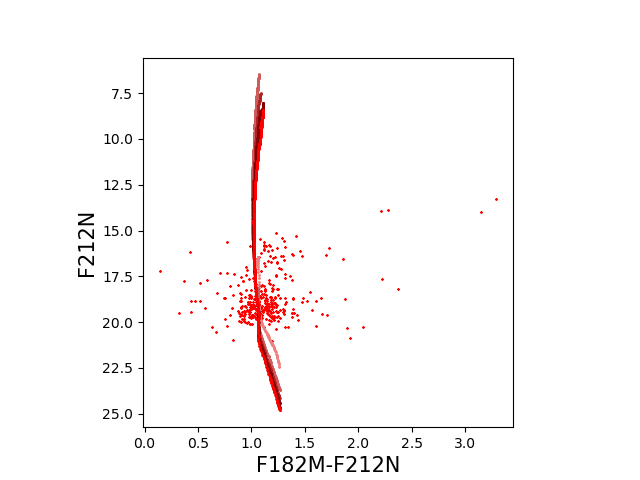

In [34]:
#F182M-F212N vs F212N

idx, d2d, d3d = F182M_coords.match_to_catalog_sky(F212N_coords) #Crossmatch the coordinate lists
F182M_F212N_mag = []
F212N_mag = []

for x in range(iX):
    if float(d2d[x].to(u.arcsec)/u.arcsec)<0.1: #Impose a minimum separation for corresponding sources to be considered
        F212N_mag.append(F212N['aper_total_vegamag'][idx[x]])
        F182M_F212N_mag.append(F182M['aper_total_vegamag'][x]-F212N['aper_total_vegamag'][idx[x]])
        
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=F182M_F212N_mag, y=F212N_mag, marker = '*', s=1, color='red', zorder=5)
isos = [0, 2, 4, 6, 8, 10]
color_arr = ["lightcoral", "indianred", "firebrick", "maroon", "darkred", "red"]
for i in range(len(isos)):
    X = instances[isos[i]].points['m_jwst_F182M'] - instances[isos[i]].points['m_jwst_F212N']
    Y = instances[isos[i]].points['m_jwst_F212N']
    ax.scatter(x=X, y=Y, marker='o', s=1, color=color_arr[i], zorder=5)

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('F182M-F212N', fontsize='15')
ax.set_ylabel('F212N', fontsize='15')
plt.gca().invert_yaxis()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')